# **Object Detection: การตรวจจับวัตถุ**

การตรวจจับวัตถุเป็นการสร้างโมเดลที่สามารถอ่านภาพและทำนายตำแหน่งของวัตถุจากภาพได้ ไลบรารี่ในการสร้างโมเดลตรวจจับวัตถุมีตัวเลือกมากมายได้แก่ `torchvision`, [`mmdetection`](https://github.com/open-mmlab/mmdetection) และ `icevision` ใน Notebook นี้เราจะมาลงมือทดลองสร้างและเทรนโมเดลสำหรับ Object Detection เบื้องต้นด้วยไลบรารี่ Icevision กัน Icevision มีข้อดีคือเราสามารถเขียนชุดข้อมูล Object detection จากไฟล์ประเภท CSV และเทรนโมเดลได้อย่างรวดเร็ว

ตัวอย่างจาก [AI builders](https://github.com/ai-builders/curriculum/blob/main/notebooks/05v_object_detection.ipynb)

## โหลด dataset สำหรับ object detection จาก Kaggle

ในแบบฝึกหัดนี้เราจะดาวน์โหลดชุดข้อมูลตัวอย่างจากเว็บไซต์ Kaggle ที่ชื่อว่า [Monkey, Cat and Dog detection](https://www.kaggle.com/datasets/tarunbisht11/yolo-animal-detection-small) เพื่อสร้างโมเดล Object detection กัน

ก่อนเริ่มสร้างโมเดล เราจะดาวน์โหลด `kaggle.json` จาก Account > API > Create API Token จากนั้นสามารถใช้ library `kaggle` เพื่อทำการดาวน์โหลดข้อมูลมายังโฟลเดอร์ที่เราต้องการได้

In [ ]:
!pip install kaggle

In [ ]:
## Set up Kaggle API
## upload your kaggle.json file to colab workspace first
## before running this cell

!mkdir /root/.kaggle
!cp kaggle.json /root/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d tarunbisht11/yolo-animal-detection-small
!unzip yolo-animal-detection-small.zip -d yolo-animal-small

In [ ]:
import pandas as pd
import os.path as op
from pathlib import Path
from PIL import Image

In [ ]:
annotation_df = pd.read_csv("yolo-animal-small/train.csv")
annotation_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,cats_001.jpg,474,266,cat,132,1,347,264
1,cats_002.jpg,474,474,cat,176,44,467,433
2,cats_003.jpg,474,314,cat,53,1,397,314
3,cats_004.jpg,474,355,cat,1,1,393,335
4,cats_005.jpg,474,316,cat,80,1,407,316


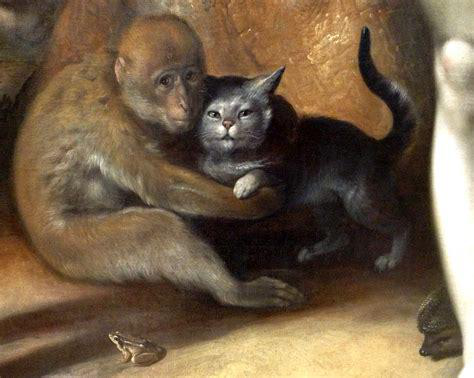

In [ ]:
Image.open("yolo-animal-small/yolo-animal-detection-small/train/cats_and_monkeys_097.jpg")

In [ ]:
# รวมขอบทั้ง 4 ของกล่อง bounding box ไว้ใน column ที่ชื่อ bbox
annotation_df["bbox"] = annotation_df.apply(
    lambda r: [r["xmin"], r["ymin"], r["xmax"] - r["xmin"], r["ymax"] - r["ymin"]],
    axis=1
)
# คำนวณ area ของแต่ละกล่อง bounding box
annotation_df["area"] = annotation_df.apply(lambda r: r["bbox"][2] * r["bbox"][3], axis=1)
# ดึง id ของแต่ละภาพจากชื่อไฟล์
annotation_df["id"] = annotation_df.filename.map(lambda x: Path(x).stem)

In [ ]:
annotation_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,bbox,area,id
0,cats_001.jpg,474,266,cat,132,1,347,264,"[132, 1, 215, 263]",56545,cats_001
1,cats_002.jpg,474,474,cat,176,44,467,433,"[176, 44, 291, 389]",113199,cats_002
2,cats_003.jpg,474,314,cat,53,1,397,314,"[53, 1, 344, 313]",107672,cats_003
3,cats_004.jpg,474,355,cat,1,1,393,335,"[1, 1, 392, 334]",130928,cats_004
4,cats_005.jpg,474,316,cat,80,1,407,316,"[80, 1, 327, 315]",103005,cats_005


In [ ]:
# จัดเรียงข้อมูลใหม่ และดึงออกมาเพียงแค่ column ที่ต้องการ (id, width, height)
img_df = annotation_df.groupby("id").first().reset_index()[["id", "width", "height"]]

# เพิ่ม path ที่อยู่ของรูปภาพเข้าไปที่ชื่อไฟล์
img_df["file_name"] = img_df.id.map(lambda p: op.join("yolo-animal-small/yolo-animal-detection-small/train/", f"{p}.jpg"))

In [ ]:
img_df.head()

,id,width,height,file_name
0,cats_001,474,266,yolo-animal-small/yolo-animal-detection-small/...
1,cats_002,474,474,yolo-animal-small/yolo-animal-detection-small/...
2,cats_003,474,314,yolo-animal-small/yolo-animal-detection-small/...
3,cats_004,474,355,yolo-animal-small/yolo-animal-detection-small/...
4,cats_005,474,316,yolo-animal-small/yolo-animal-detection-small/...


### **Use IceVision for Training**

Install icevision จาก source code ของ icevision
(คำสั่งต่อไปนี้จะ  restart notebook เพื่อให้มีการใช้งาน icevision ที่เพิ่งติดตั้งได้)

In [ ]:
!wget https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh
!bash icevision_install.sh cuda11

# Restart kernel after installation
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

In [ ]:
# import all the things we need again.
import os.path as op
import pandas as pd
from icevision.all import *

INFO     - Downloading mmdet configs | icevision.models.mmdet.download_configs:download_mmdet_configs:31


0B [00:00, ?B/s]

In [ ]:
df = pd.read_csv("yolo-animal-small/train.csv")
df.rename(columns={"class": "label"}, inplace=True)

df.to_csv("yolo-animal-small/train_annotation.csv", index=False)

df.head()

In [ ]:
template_record = ObjectDetectionRecord()

In [ ]:
class YoloSmallDataset(Parser): # inherit from Parser class in icevision
    def __init__(self, template_record):
        super().__init__(template_record=template_record)
        self.df = pd.read_csv("yolo-animal-small/train_annotation.csv")
        self.class_map = ClassMap(list(self.df['label'].unique())) # ClassMap class in icevision

    def __iter__(self) -> Any:
        for o in self.df.itertuples():
            yield o

    def __len__(self) -> int:
        return len(self.df)

    def record_id(self, o) -> Hashable:
        return o.filename

    def parse_fields(self, o, record, is_new):
        if is_new:
            record.set_filepath(op.join("yolo-animal-small/yolo-animal-detection-small/", "train", o.filename))
            record.set_img_size(ImgSize(width=o.width, height=o.height))
            record.detection.set_class_map(self.class_map)

        record.detection.add_bboxes([BBox.from_xyxy(o.xmin, o.ymin, o.xmax, o.ymax)])
        record.detection.add_labels([o.label])

In [ ]:
parser = YoloSmallDataset(template_record)
train_records, valid_records = parser.parse()

  0%|          | 0/1309 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/469 [00:00<?, ?it/s]

In [ ]:
len(train_records), len(valid_records)

(375, 94)

In [ ]:
model_type = models.mmdet.retinanet # เลือก model architecture ที่ต้องการใช้
backbone = model_type.backbones.resnet50_fpn_1x # เลือก backbone ที่ต้องการใช้ภายใน model_type

In [ ]:
# กำหนด transformations และ augmentations ต่างๆ
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=224, presize=512), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(224), tfms.A.Normalize()])

In [ ]:
# สร้าง Dataset ของ train และ valid ที่จะใช้ในการ train และ validate โมเดล
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

In [ ]:
# สร้าง dataloaders
train_dl = model_type.train_dl(train_ds, batch_size=8, num_workers=4, shuffle=True)
valid_dl = model_type.train_dl(train_ds, batch_size=8, num_workers=4, shuffle=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### ลองดูรูปภาพใน dataset และ bounding boxes

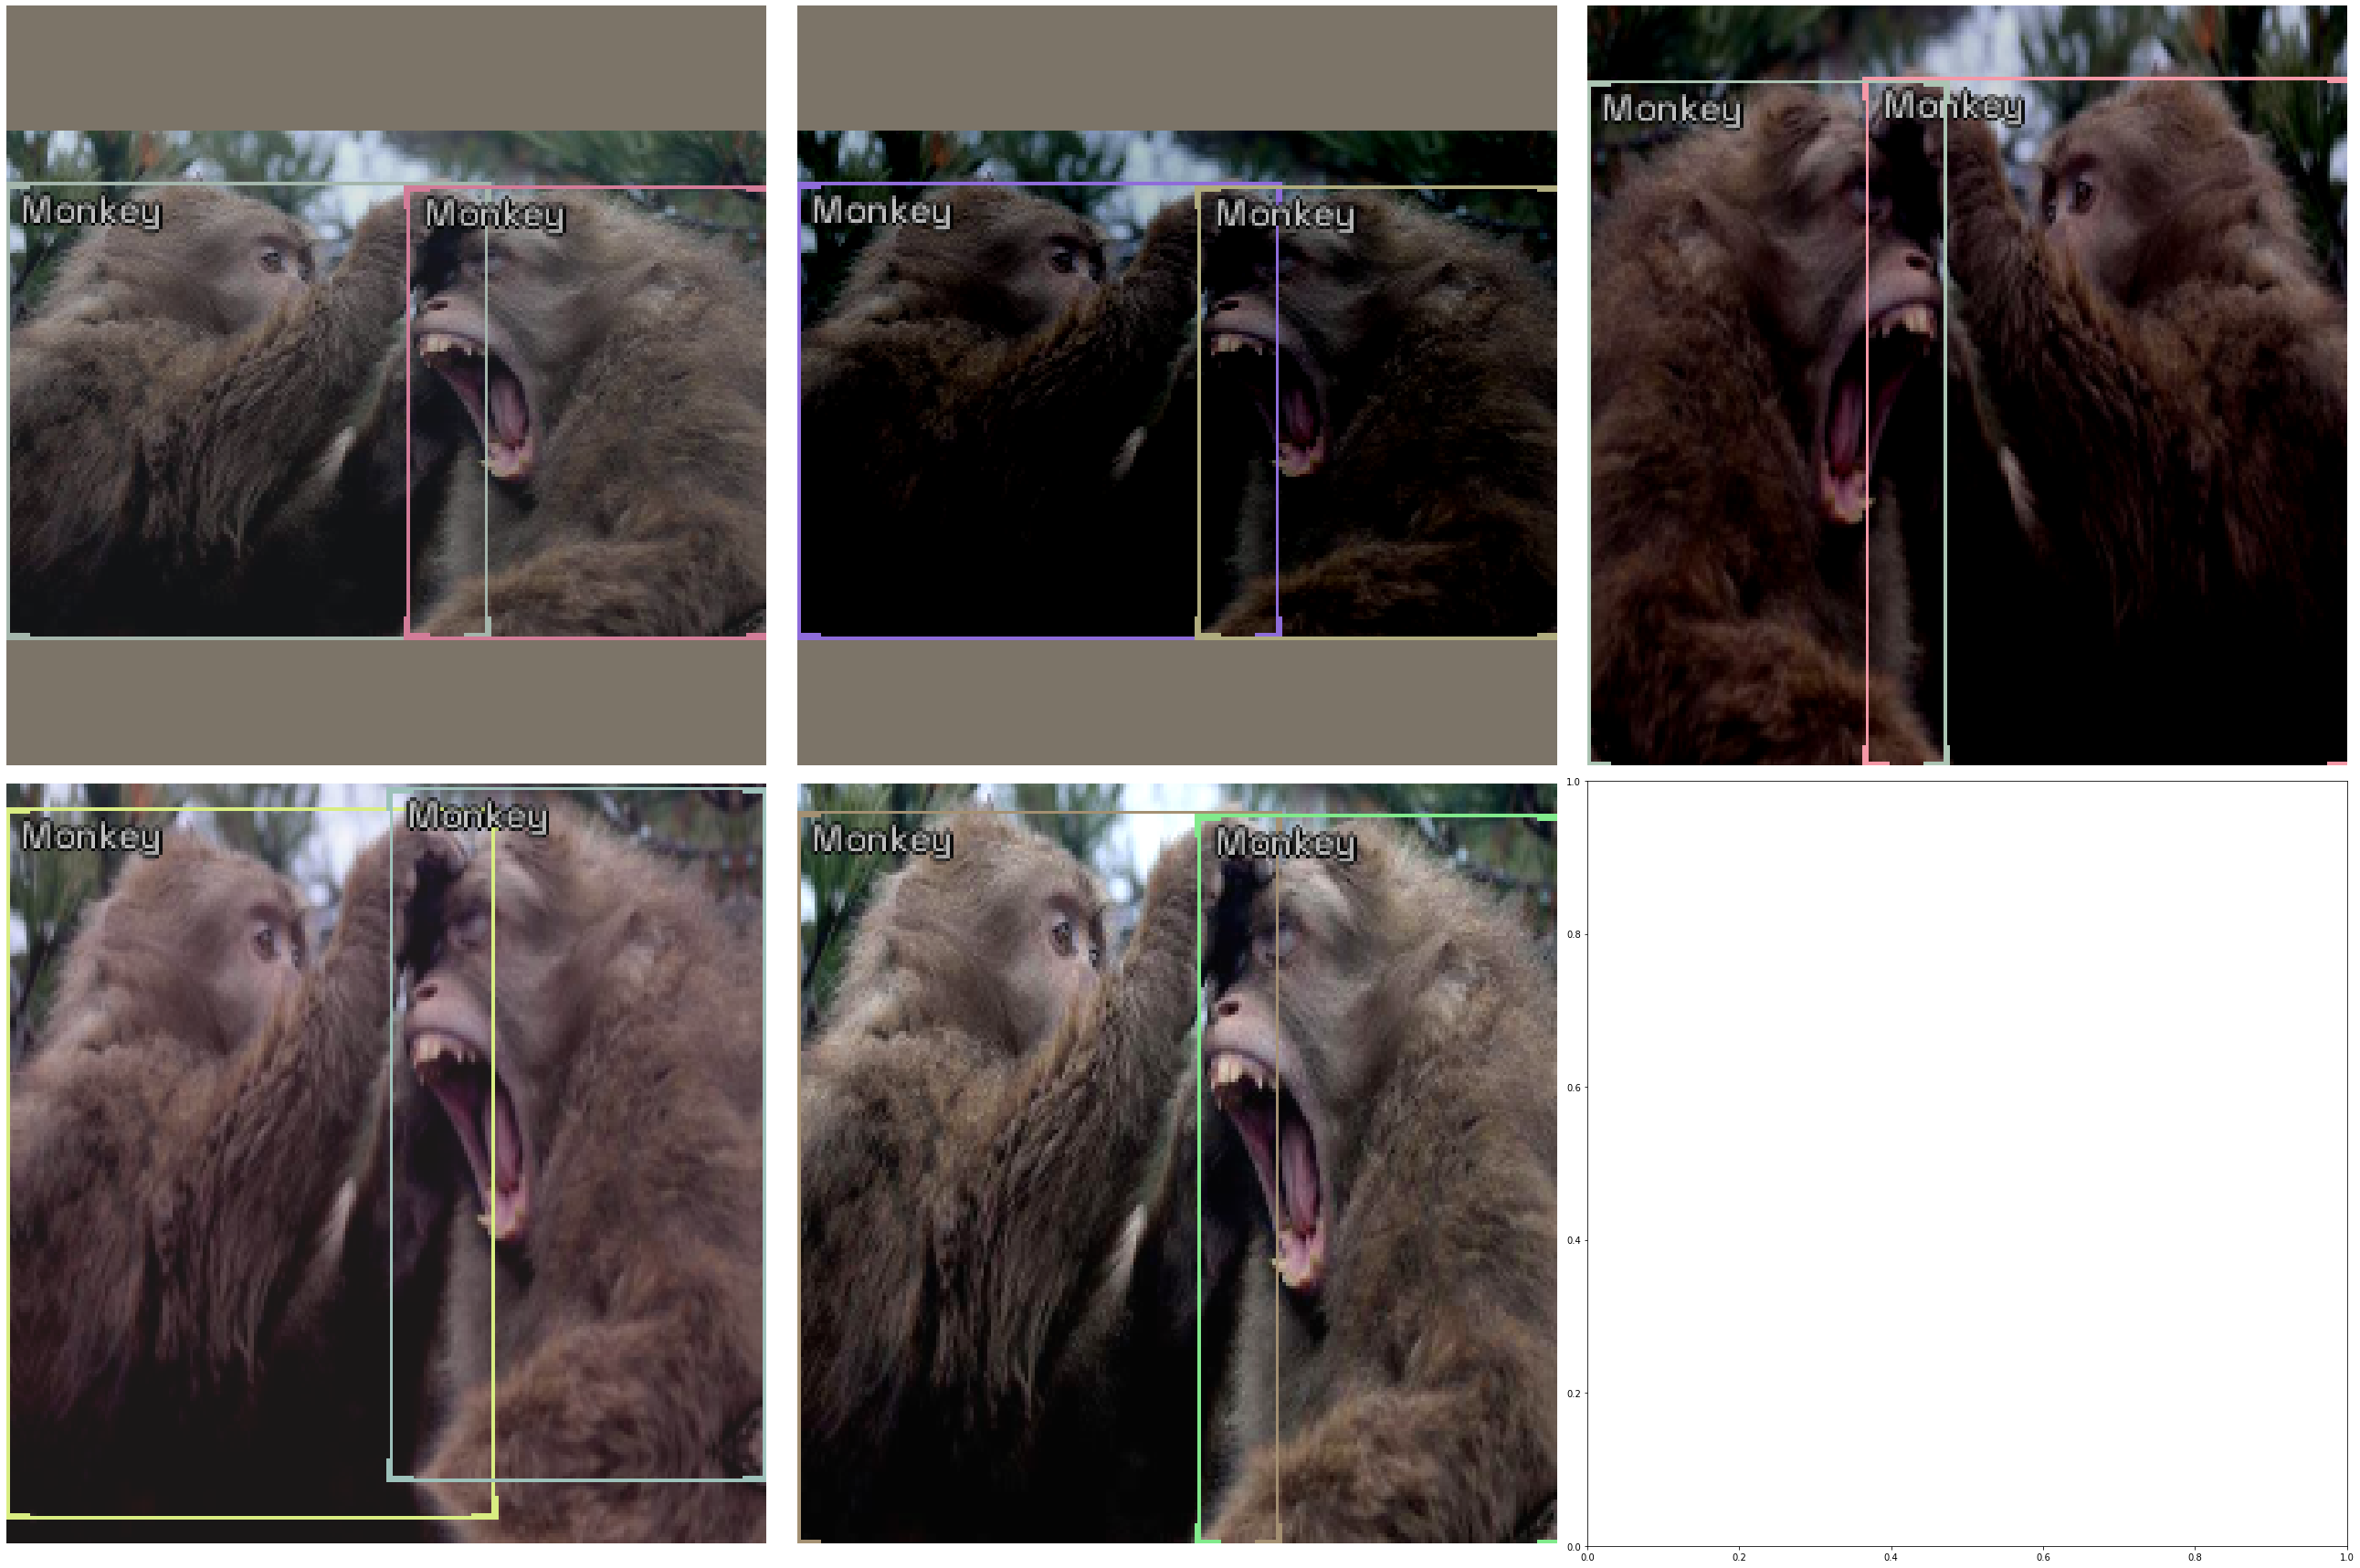

In [ ]:
samples = [train_ds[10] for _ in range(5)]
show_samples(samples, ncols=3)

### สร้างโมเดลสำหรับ object detection

In [ ]:
model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(parser.class_map))

  0%|          | 0/152149505 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/builder.py:17: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  '``build_anchor_generator`` would be deprecated soon, please use '
2022-08-02 05:38:54,792 - mmcv - INFO - initialize ResNet with init_cfg {'type': 'Pretrained', 'checkpoint': 'torchvision://resnet50'}
2022-08-02 05:38:54,794 - mmcv - INFO - load model from: torchvision://resnet50
2022-08-02 05:38:54,797 - mmcv - INFO - load checkpoint from torchvision path: torchvision://resnet50
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

2022-08-02 05:38:55,519 - mmcv - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

2022-08-02 05:38:55,554 - mmcv - INFO - initialize FPN with init_cfg {'type': 'Xavier', 'layer': 'Conv2d', 'distribution': 'uniform'}
2022-08-02 05:38:55,621 - mmcv - INFO - initialize RetinaHead with init_cfg {'type': 'Normal', 'layer': 'Conv2d', 'std': 0.01, 'override': {'type': 'Normal', 'name': 'retina_cls', 'std': 0.01, 'bias_prob': 0.01}}
2022-08-02 05:38:55,662 - mmcv - INFO - 
backbone.conv1.weight - torch.Size([64, 3, 7, 7]): 
PretrainedInit: load from torchvision://resnet50 
 
2022-08-02 05:38:55,664 - mmcv - INFO - 
backbone.bn1.weight - torch.Size([64]): 
PretrainedInit: load from torchvision://resnet50 
 
2022-08-02 05:38:55,667 - mmcv - INFO - 
backbone.bn1.bias - torch.Size([64]): 
PretrainedInit: load from torchvision://resnet50 
 
2022-08-02 05:38:55,670 - mmcv - INFO - 
backbone.layer1.0.conv1.weight - torch.Size([64

load checkpoint from local path: checkpoints/retinanet/retinanet_r50_fpn_1x_coco_20200130-c2398f9e.pth
The model and loaded state dict do not match exactly

size mismatch for bbox_head.retina_cls.weight: copying a param with shape torch.Size([720, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([27, 256, 3, 3]).
size mismatch for bbox_head.retina_cls.bias: copying a param with shape torch.Size([720]) from checkpoint, the shape in current model is torch.Size([27]).


In [ ]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]
learner = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


SuggestedLRs(valley=7.585775892948732e-05)

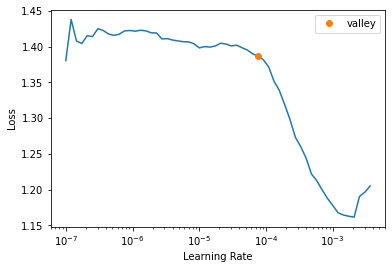

In [ ]:
learner.lr_find() # หา learning rate ที่เหมาะสมอัตโนมัติ

In [ ]:
learner.fine_tune(20, 1e-4, freeze_epochs=1)

epoch,train_loss,valid_loss,COCOMetric,time
0,1.011266,0.703652,0.250489,00:24


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


epoch,train_loss,valid_loss,COCOMetric,time
0,0.581516,0.554488,0.324426,00:24
1,0.547055,0.512441,0.385246,00:24
2,0.519089,0.476177,0.425590,00:24
3,0.489609,0.448719,0.469958,00:24
4,0.463818,0.427456,0.488131,00:25
5,0.444630,0.410633,0.506206,00:23
6,0.428505,0.395380,0.520326,00:23
7,0.407022,0.376399,0.539414,00:24
8,0.388862,0.366970,0.553440,00:23
9,0.373051,0.358059,0.564452,00:24


In [ ]:
from icevision.models import *

In [ ]:
m = ClassMap(list(df['label'].unique()))
m.get_classes()

['background', 'cat', 'monkey', 'dog']

In [ ]:
import icevision

# เซฟโมเดลด้วยคำสั่ง `save_icevision_checkpoint`
checkpoint_path = "monkeycatdog_det.pth"
save_icevision_checkpoint(
    model, 
    model_name='mmdet.retinanet', 
    backbone_name='resnet50_fpn_1x',
    classes=m.get_classes(),
    img_size=224,
    filename=checkpoint_path,
    meta={"icevision_version": icevision.__version__}
)

### Example predictions

เราสามารถดาวน์โหลดโมเดลที่เทรนเสร็จแล้วเพื่อทำนายชุดข้อมูลที่โมเดลไม่เคยเห็นมาก่อนได้

In [ ]:
# โหลดโมเดลที่เซฟมาเพื่อทำนายผลใน validation set
model_loaded = model_from_checkpoint("monkeycatdog_det.pth")

load checkpoint from local path: monkeycatdog_det.pth


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/builder.py:17: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  '``build_anchor_generator`` would be deprecated soon, please use '
2022-08-02 05:58:20,931 - mmcv - INFO - initialize ResNet with init_cfg {'type': 'Pretrained', 'checkpoint': 'torchvision://resnet50'}
2022-08-02 05:58:20,933 - mmcv - INFO - load model from: torchvision://resnet50
2022-08-02 05:58:20,935 - mmcv - INFO - load checkpoint from torchvision path: torchvision://resnet50
2022-08-02 05:58:21,033 - mmcv - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

2022-08-02 05:58:21,071 - mmcv - INFO - initialize FPN with init_cfg {'type': 'Xavier', 'layer': 'Conv2d', 'distribution': 'uniform'}
2022-08-02 05:58:21,129 - mmcv - INFO - initialize RetinaHead with init_cfg {'type': 'Normal', 'layer': 'Conv2d', 'std': 0.01, 'override': {'type': 'N

In [ ]:
model_type = model_loaded["model_type"]
backbone = model_loaded["backbone"]
class_map = model_loaded["class_map"]
img_size = model_loaded["img_size"]
model_type, backbone, class_map, img_size

(<module 'icevision.models.mmdet.models.retinanet' from '/usr/local/lib/python3.7/dist-packages/icevision/models/mmdet/models/retinanet/__init__.py'>,
 <ClassMap: {'background': 0, 'cat': 1, 'monkey': 2, 'dog': 3}>,
 224)

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


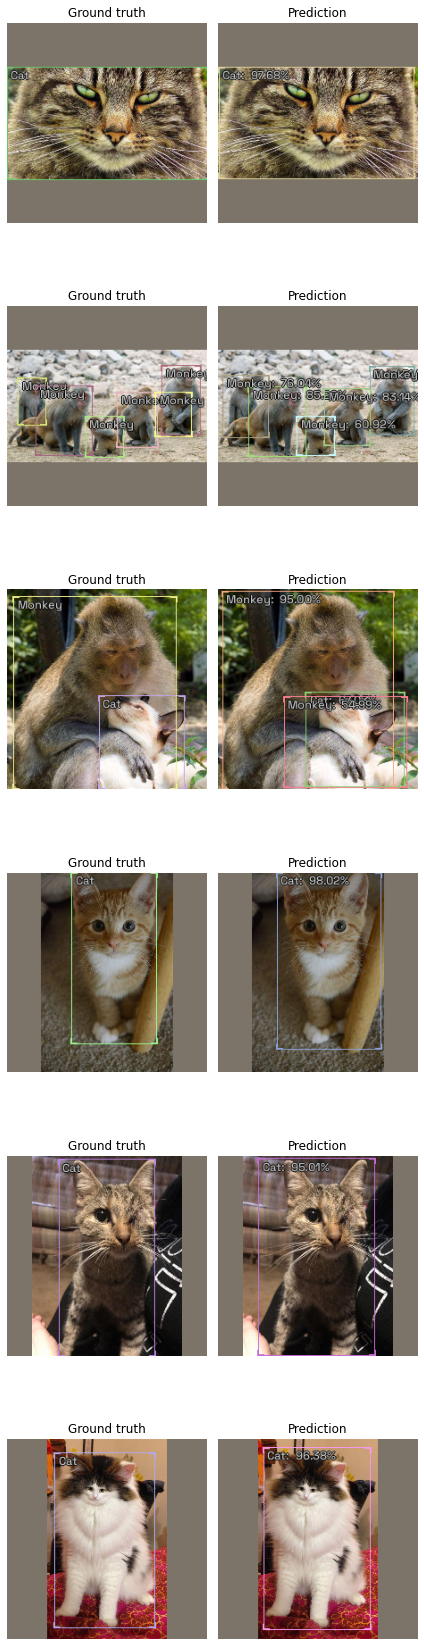

In [ ]:
model_type.show_results(model_loaded["model"], valid_ds, detection_threshold=0.4)

### Single Image Inference

นอกจากนั้นเรายังสามารถใช้คำสั่ง `model_type.end2end_detect` เพื่อทำนายภาพที่สนใจภาพเดียวได้เช่นกัน

In [ ]:
from PIL import Image

file_name = "yolo-animal-small/yolo-animal-detection-small/test/cats_007.jpg"
img = Image.open(file_name)
pred_dict  = model_type.end2end_detect(img, valid_tfms, model, class_map=class_map, detection_threshold=0.5)
pred_dict['img']